# DNN Inferece Test Bench
### Mario L. NCL, 2017
BVLC Caffe Implementation

### 1. Setup python packages (Python 3.5.2)


In [1]:
# Set up Python environment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os

# Specify Python path for caffe modules
caffe_root = '../'  
sys.path.insert(0, caffe_root + 'python')
import caffe

# Set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        
plt.rcParams['image.interpolation'] = 'nearest'  # no interpolation; show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than misleading color heatmap

In [2]:
#bvlc_alexnet)
if os.path.isfile(caffe_root + 'models/bvlc_alexnet/bvlc_alexnet.caffemodel'): #bvlc_alexnet) 
#han_alexnet)  if os.path.isfile('/home/gvkalra/mario/channel-pruning/temp/models/han_alexnet/han_alexnet.caffemodel'): #han_alexnet)

#vgg) if os.path.isfile('/home/gvkalra/mario/channel-pruning/temp/models/vgg-16_original_model/vgg.caffemodel'):#vgg)
#pruned_vgg)if os.path.isfile('/home/gvkalra/mario/channel-pruning/temp/models/pruned-VGG-16_5x/channel_pruning.caffemodel'): #pruned_vgg)     
    print ('model found.')
else:
    print('model not found!')

model found.


### 2. Load network and perform input preprocessing


In [3]:
caffe.set_mode_cpu()

#bvlc_alexnet) 
model_weights = caffe_root + 'models/bvlc_alexnet/bvlc_alexnet.caffemodel' #bvlc_alexnet)
#bvlc_alexnet) 
model_def = caffe_root + 'models/bvlc_alexnet/deploy.prototxt' #bvlc_alexnet)

#han_alexnet)  model_weights = '/home/gvkalra/mario/channel-pruning/temp/models/han_alexnet/han_alexnet.caffemodel' #han_alexnet)
#han_alexnet)  model_def = caffe_root + 'models/bvlc_alexnet/deploy.prototxt' #han_alexnet)

#vgg) model_weights =  '/home/gvkalra/mario/channel-pruning/temp/models/vgg-16_original_model/vgg.caffemodel' #vgg)
#vgg) model_def = '/home/gvkalra/mario/channel-pruning/temp/models/vgg-16_original_model/deploy.prototxt' #vgg)

#pruned_vgg) model_weights = '/home/gvkalra/mario/channel-pruning/temp/models/pruned-VGG-16_5x/channel_pruning.caffemodel' #pruned_vgg)
#pruned_vgg) model_def = '/home/gvkalra/mario/channel-pruning/temp/models/pruned-VGG-16_5x/deploy.prototxt' #pruned_vgg)

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# The default network is configured to take images in BGR format. 
# Values are in the range [0, 255] and have the mean ImageNet pixel value subtracted from them. 
# The channel dimension is expected as the first (_outermost_) dimension.
#    Note: Matplotlib loads images with values in the range [0, 1] in RGB format with the channel 
#    as the _innermost_ dimension, so we are arranging for the needed transformations.

# Load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print ('mean-subtracted values:', list(zip('BGR', mu)))

# Create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

# Set the size of the input 
net.blobs['data'].reshape(32,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size (227x227 for AlexNet )(224x224 for VGGnet)

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


--2017-10-17 20:43:26--  https://i.pinimg.com/736x/3b/bc/d7/3bbcd721fc7b53e3a7655aa0b77b6441--cutest-puppy-cutest-dogs.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.74.149.41, 2600:140b:10:1b2::1168, 2600:140b:10:1ad::1168
Connecting to i.pinimg.com (i.pinimg.com)|104.74.149.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49311 (48K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  48.16K  --.-KB/s    in 0.01s   

2017-10-17 20:43:26 (3.62 MB/s) - ‘image.jpg’ saved [49311/49311]



/home/gvkalra/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


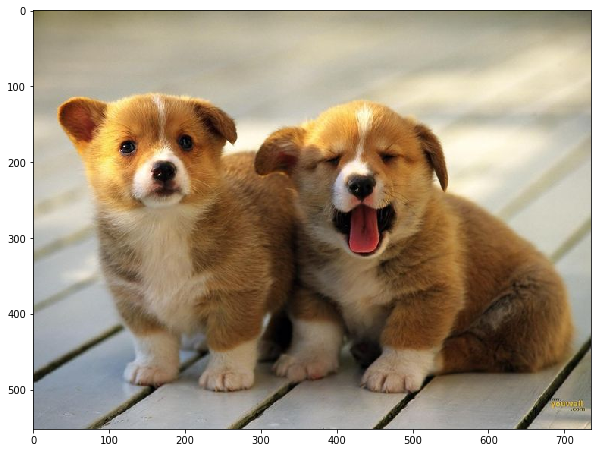

In [4]:
# Download  image
image_url = "https://i.pinimg.com/736x/3b/bc/d7/3bbcd721fc7b53e3a7655aa0b77b6441--cutest-puppy-cutest-dogs.jpg"  
!wget -O image.jpg $image_url

# Transform the image and copy it into the net object blob
image = caffe.io.load_image('image.jpg')
#image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

### Optional: Evaluate inference accuracy

In [5]:
caffe.set_device(0)  # set working device (GPU)
caffe.set_mode_gpu()
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print ('predicted class is:', output_prob.argmax())

# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    print('synset labels file not found!')
        
labels = np.loadtxt(labels_file, str, delimiter='\t')

print ('Top 1 output label:', labels[output_prob.argmax()])

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print ('Top 5 probabilities and labels:')
out = list(zip( output_prob[top_inds], labels[top_inds]))
print(out)

predicted class is: 207
Top 1 output label: n02099601 golden retriever
Top 5 probabilities and labels:
[(0.39484906, 'n02099601 golden retriever'), (0.36663359, 'n02113023 Pembroke, Pembroke Welsh corgi'), (0.14375691, 'n02113186 Cardigan, Cardigan Welsh corgi'), (0.019754278, 'n02085620 Chihuahua'), (0.011566354, 'n02108551 Tibetan mastiff')]


### Optional 2: Evaluate performace CPU

In [ ]:
caffe.set_mode_cpu()
%timeit net.forward()

### 3. Evaluate inference performance (GPU)

In [6]:
caffe.set_device(0)  # set working device (GPU)
caffe.set_mode_gpu()
net.forward()  # pre-run for memory set-up (warm-up)
%timeit net.forward()

9.27 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


----------------------------------------------------------------------------------------
## Pruning sensitivity analysis (tools) 

### Extra: Examine layers-by-layer activations 



In [ ]:
# Layer activations typical shape: (batch_size, channel_dim, height, width).
#    Note: The activations are exposed as an `OrderedDict`, `net.blobs`.

# For each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print (layer_name + '\t' + str(blob.data.shape))

# Parameter shapes are exposed as another `OrderedDict`, `net.params`. 
# Index the resulting values with either `[0]` for weights or `[1]` for biases.
#    Note: The param shapes typically have the form 
#    (output_channels, input_channels, filter_height, filter_width) (for the weights) 
#    and the 1-dimensional shape (output_channels,) (for the biases).
    
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

In [ ]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # Force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there exist any)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # Tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [ ]:
# Visualize the first layer (or whichever is desired)

# Parameters are contained in a  list of form [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [ ]:
# First layer output, `conv1` (rectified responses of the above filters, first 36 only)
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

In [ ]:
# Fifth layer after pooling, `pool5`
feat = net.blobs['pool5'].data[0]
vis_square(feat)

In [ ]:
# First fully connected layer, `fc6` (rectified)
# Show the output values and the histogram of the positive values

feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

In [ ]:
# The final probability output, `prob` (the more compact the spike is the better)
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

### Extra 2: Test extra images



In [ ]:
# Download an image
image_url = "..."  # paste URL here
!wget -O sample.jpg $image_url

# Transform the image and copy it into the net object blob
image = caffe.io.load_image('sample.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# Perform classification
net.forward()

# Obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# Sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)
print ('probabilities and labels :',list(zip(output_prob[top_inds], labels[top_inds]))
